# Part 1: Module and data import

In [1]:
# this lets us use the figures interactively
%matplotlib inline

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.geometry import Point, LineString, Polygon

plt.ion() # make the plotting interactive

In [2]:
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [3]:
def scale_bar(ax, location=(0.32, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-1000, '10 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-5000, sby-1000, '5 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-10000, sby-1000, '0 km', transform=ax.projection, fontsize=10)


In [4]:
#import data file: flood, buildings, roads, population excel file, county outline, sa outline
flood= gpd.read_file(os.path.abspath('Project_datafiles/Flood_2m.shp'))
roads= gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_roads.shp'))
buildings= gpd.read_file(os.path.abspath('Project_datafiles/Building_Fermanagh.shp'))
pop_demography=gpd.read_file(os.path.abspath('Project_datafiles/popdemography.csv'))
outline = gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_DCA.shp'))
small_area= gpd.read_file(os.path.abspath('Project_datafiles/SApoly.shp'))
land_cover= gpd.read_file(os.path.abspath('Project_datafiles/LC_Fermanagh.shp'))

In [5]:
small_area =gpd.GeoDataFrame(pop_demography.merge(small_area, on="SA2011"))
small_area.head()

,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,geometry_y
0,N00002840,1431,206,170,None,95OO09W1,254975.0,348366.0,6501.2300,1165.959442,8.887880e+03,"POLYGON ((252811.562 343516.812, 252805.719 34..."
1,N00002875,1081,139,201,None,95OO16W1,245853.0,352166.0,4642.3600,16465.931517,2.435332e+05,"MULTIPOLYGON (((243534.693 349935.659, 243523...."
2,N00002876,531,78,63,None,95OO16W1,248710.0,346505.0,3133.7100,24116.723771,1.552702e+05,"MULTIPOLYGON (((249689.520 342125.283, 249724...."
3,N00002878,205,17,54,None,95OO16W1,243822.0,347918.0,41.5643,1432.148481,1.148343e+04,"POLYGON ((243255.547 348262.219, 243259.156 34..."
4,N00002912,345,38,69,None,95PP01W1,225525.0,348857.0,1255.1600,26671.860028,1.255163e+07,"POLYGON ((227161.047 350213.156, 227161.109 35..."


In [6]:
small_area.rename(columns={'geometry_y':'geometry'}, inplace=True)

small_area.set_geometry('geometry')

,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,geometry
0,N00002840,1431,206,170,None,95OO09W1,254975.0,348366.0,6501.2300,1165.959442,8.887880e+03,"POLYGON ((252811.562 343516.812, 252805.719 34..."
1,N00002875,1081,139,201,None,95OO16W1,245853.0,352166.0,4642.3600,16465.931517,2.435332e+05,"MULTIPOLYGON (((243534.693 349935.659, 243523...."
2,N00002876,531,78,63,None,95OO16W1,248710.0,346505.0,3133.7100,24116.723771,1.552702e+05,"MULTIPOLYGON (((249689.520 342125.283, 249724...."
3,N00002878,205,17,54,None,95OO16W1,243822.0,347918.0,41.5643,1432.148481,1.148343e+04,"POLYGON ((243255.547 348262.219, 243259.156 34..."
4,N00002912,345,38,69,None,95PP01W1,225525.0,348857.0,1255.1600,26671.860028,1.255163e+07,"POLYGON ((227161.047 350213.156, 227161.109 35..."
...,...,...,...,...,...,...,...,...,...,...,...,...
162,N00004441,550,74,57,None,95YY21W1,229920.0,357951.0,1832.3300,4692.957044,2.793306e+04,"MULTIPOLYGON (((228974.460 355263.986, 228974...."
163,N00004442,545,89,69,None,95YY21W1,237867.0,357468.0,2612.6500,8305.400422,5.415938e+04,"MULTIPOLYGON (((237579.828 354628.375, 237579...."
164,N00004443,612,103,83,None,95YY21W1,234595.0,356093.0,2228.5100,5058.592762,2.032710e+04,"MULTIPOLYGON (((234708.016 352733.406, 234705...."
165,N00004445,405,70,61,None,95YY21W1,231610.0,353656.0,1466.9700,13909.298102,1.125557e+05,"MULTIPOLYGON (((231942.312 350909.781, 231924...."


In [7]:
small_area['residents'] = small_area['residents'].astype(int)
small_area['Shape_Area'] = small_area['Shape_Area'].astype(int)


In [8]:
for ind, row in small_area.iterrows(): # iterate over each row in the GeoDataFrame
    small_area.loc[ind, 'pop_density'] = row['residents']/ row['Shape_Area']* 1000000
print(small_area.head())

      SA2011  residents children elderly geometry_x   SOA2011   X_COORD   
0  N00002840       1431      206     170       None  95OO09W1  254975.0  \
1  N00002875       1081      139     201       None  95OO16W1  245853.0   
2  N00002876        531       78      63       None  95OO16W1  248710.0   
3  N00002878        205       17      54       None  95OO16W1  243822.0   
4  N00002912        345       38      69       None  95PP01W1  225525.0   

    Y_COORD   Hectares    Shape_Leng  Shape_Area   
0  348366.0  6501.2300   1165.959442        8887  \
1  352166.0  4642.3600  16465.931517      243533   
2  346505.0  3133.7100  24116.723771      155270   
3  347918.0    41.5643   1432.148481       11483   
4  348857.0  1255.1600  26671.860028    12551625   

                                            geometry    pop_density  
0  POLYGON ((252811.562 343516.812, 252805.719 34...  161021.717115  
1  MULTIPOLYGON (((243534.693 349935.659, 243523....    4438.823486  
2  MULTIPOLYGON (((249689.

In [9]:
small_area['pop_density'].describe()

count       167.000000
mean       2885.519657
std       15014.240918
min           3.715240
25%          24.111430
50%          85.567990
75%         866.234584
max      161021.717115
Name: pop_density, dtype: float64

In [10]:
flood.to_crs(epsg = 2157)
roads.to_crs(epsg = 2157)
buildings.to_crs(epsg = 2157)
outline.to_crs(epsg = 2157)
small_area.to_crs(epsg = 2157)
land_cover.to_crs(epsg = 2157)

,SEGID,TOTPIXELS,COREPIXELS,BHSUB,LAND_COVER,Shape_Leng,Shape_Area,geometry
0,H000009r1,1785,1040,6.1,Neutral grass,20700.000000,1.115625e+06,"POLYGON ((597303.594 849201.689, 597303.594 84..."
1,H000015r1,2031,1419,7.1,Calcareous grass,17300.000000,1.269375e+06,"POLYGON ((593529.434 854200.632, 593529.434 85..."
2,H000017r1,5148,3700,10.2,Open dwarf shrub heath,33365.445406,2.699577e+06,"POLYGON ((599078.292 864323.421, 599078.291 86..."
3,H000023r1,0,0,12.1,Bog,4630.182956,4.091334e+05,"MULTIPOLYGON (((624405.618 823638.054, 624405...."
4,H000025r1,0,0,12.1,Bog,5076.466263,2.692242e+05,"MULTIPOLYGON (((614628.752 828910.970, 614628...."
...,...,...,...,...,...,...,...,...
37831,H172275r1,23,17,16.1,Inland Bare Ground,700.000000,1.437500e+04,"POLYGON ((628854.899 868778.303, 628829.904 86..."
37832,H172276r1,23,5,10.2,Open dwarf shrub heath,750.000000,1.437500e+04,"POLYGON ((629354.791 868728.311, 629354.791 86..."
37833,H172277r1,34,7,10.2,Open dwarf shrub heath,1100.000000,2.125000e+04,"POLYGON ((629354.791 868728.311, 629329.796 86..."
37834,H172278r1,36,8,12.1,Bog,1050.000000,2.250000e+04,"POLYGON ((629454.769 868678.321, 629429.774 86..."


In [11]:
def underwater(shapefile):
    flood_geom = flood['geometry'].values[0]
    underwater = shapefile['geometry'].within(flood_geom)
    return shapefile['geometry'].within(flood_geom)


# Part 2: Landcover analyses and map

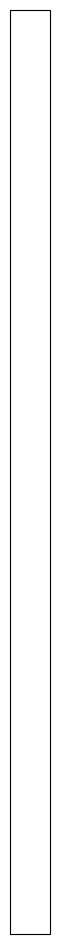

In [12]:
myFig = plt.figure(figsize=(12, 12))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [13]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = flood.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.
ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)


In [14]:
# get the number of unique municipalities we have in the dataset
landcover= len(land_cover.LAND_COVER.unique())
print('Number of unique features: {}'.format(landcover))


Number of unique features: 14


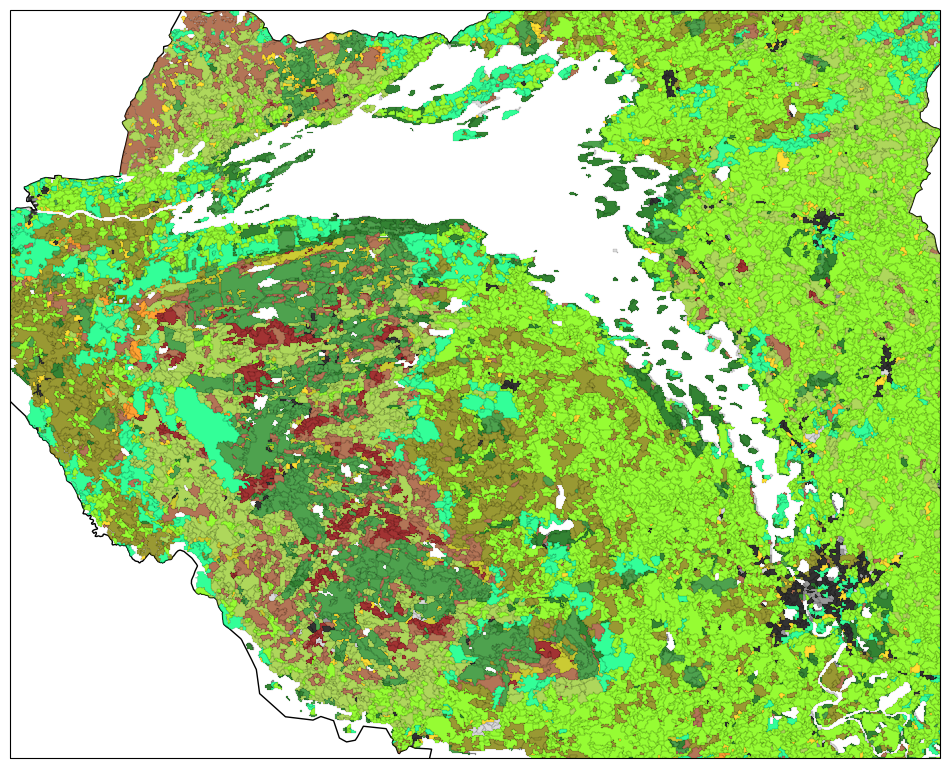

In [15]:
land_cover_colors = ['springgreen','olive', 'sienna','darkred', 'lawngreen', 'forestgreen','yellowgreen', 'y','darkgreen','darkorange','lightgrey','gold','black','grey']
landcover=list(land_cover.LAND_COVER.unique())
for ii, name in enumerate(landcover):
    feat = ShapelyFeature(land_cover.loc[land_cover['LAND_COVER'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=land_cover_colors[ii],
                        linewidth=0.1,
                         alpha=0.8) # set the face color to the corresponding color from the list
                           # set the outline width to be 1 pt
                           # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat)

myFig

In [16]:
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='k',facecolor='navy',alpha=1,linewidth=0.1)
ax.add_feature(flood_feature)


In [17]:
landcover_handles = generate_handles(land_cover.LAND_COVER.unique(), land_cover_colors)
flood_handles = generate_handles(['Flood'], ['navy'])

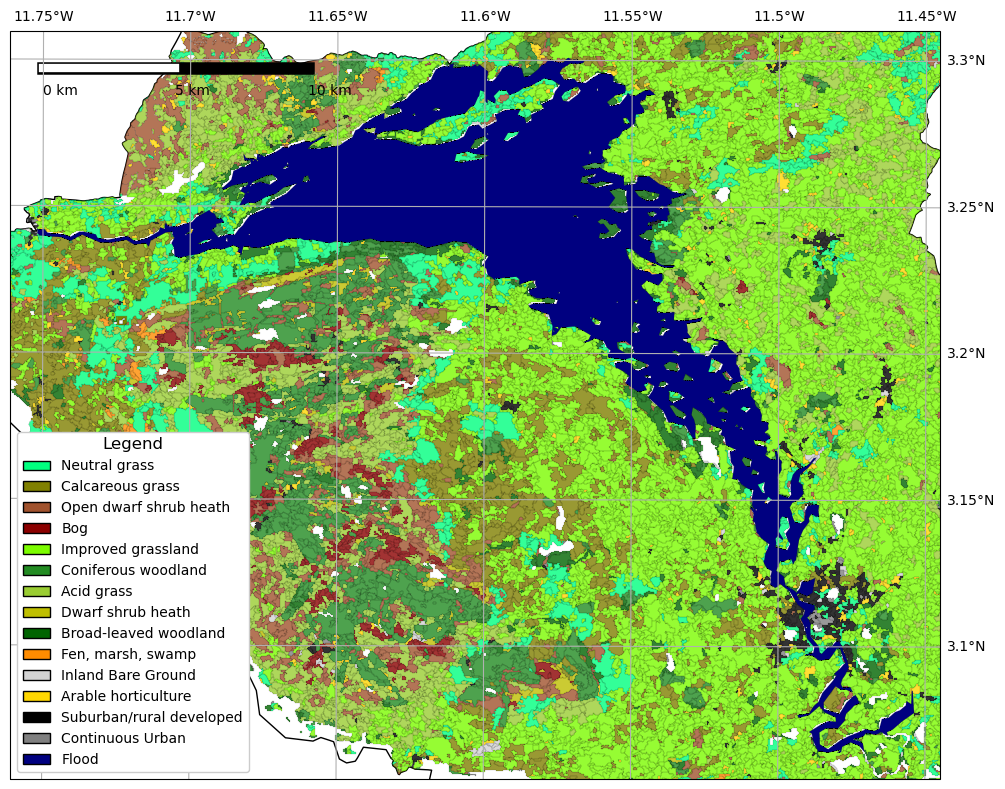

In [18]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects
# you want to add to the legend
handles = landcover_handles  + flood_handles # use '+' to concatenate (combine) lists
labels = landcover + ['Flood']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k') # draw  labels for the grid lines
                         
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False

scale_bar(ax)
myFig # to show the updated figure

In [19]:
lc_flooded = underwater(land_cover) # call underwater function to select land parcels in 5m flood zone
land_flooded = land_cover[lc_flooded] # subset the land cover shapefile to include only underwater = true
print(land_flooded[['LAND_COVER','Shape_Area']])

                  LAND_COVER  Shape_Area
7799        Continuous Urban     26250.0
7846   Broad-leaved woodland     16250.0
10389  Broad-leaved woodland     18125.0
14105  Broad-leaved woodland     18125.0
14107    Coniferous woodland     27500.0
...                      ...         ...
35196       Continuous Urban      9375.0
35220    Coniferous woodland      6875.0
35258     Inland Bare Ground     13750.0
35260    Coniferous woodland      9375.0
35261  Broad-leaved woodland     10625.0

[135 rows x 2 columns]


In [20]:
land_flooded.groupby(['LAND_COVER'])['Shape_Area'].sum().sort_values(ascending=False)

LAND_COVER
Broad-leaved woodland       767545.0
Coniferous woodland         295000.0
Inland Bare Ground          227500.0
Continuous Urban             82500.0
Open dwarf shrub heath       49554.0
Improved grassland           48750.0
Arable horticulture          36875.0
Neutral grass                20000.0
Suburban/rural developed     19596.0
Calcareous grass             13125.0
Name: Shape_Area, dtype: float64

# Part 3: Infrastructure and population analyses and map

In [21]:
build_flooded = underwater(buildings) # call underwater function to select land parcels in 5m flood zone
building_flooded = buildings[build_flooded] # subset the land cover shapefile to include only underwater = true

rd_flooded = underwater(roads) # call underwater function to select land parcels in 5m flood zone
roads_flooded = roads[rd_flooded] # subset the land cover shapefile to include only underwater = true

sa_flooded = small_area.sjoin(flood, how="inner") # call underwater function to select land parcels in 5m flood zone
 # subset the land cover shapefile to include only underwater = true
sa_flooded['SA2011'].count()

34

In [22]:
sum_roads = roads_flooded['Length'].sum() /1000
sum_motorway = roads_flooded[roads_flooded['CLASS'] == 'A']['Length'].sum() /1000
print('{:.2f} total km of roads'.format(sum_roads))
print('{:.2f} total km of A class road'.format(sum_motorway))

2.35 total km of roads
1.18 total km of A class road


In [23]:
building_flooded.groupby(['CLASSIFICA'])['CLASSIFICA'].count().sort_values(ascending=False)

CLASSIFICA
Residential    225
Other           69
Commercial      47
Health           2
Legal            1
Religious        1
Name: CLASSIFICA, dtype: int64

In [24]:
high_density= sa_flooded[sa_flooded.pop_density==sa_flooded.pop_density.max()]
print(high_density[['SA2011', 'pop_density']])

        SA2011  pop_density
134  N00003042  3491.408935


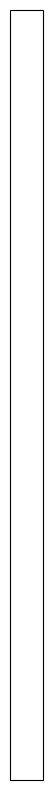

In [25]:
myFig2, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))
xmin, ymin, xmax, ymax = flood.total_bounds

  # create a figure of size 10x10 (representing the page size in inches)
  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of. 
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature


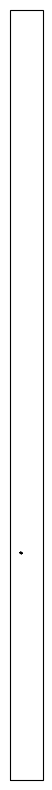

In [26]:
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
ax.add_feature(outline_feature)
#ax.add_feature(outline_feature) # add the features we've created to the map.
#ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)# finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.
myFig2

In [27]:
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='k',facecolor='navy',alpha=0.5,linewidth=0.1)
ax.add_feature(flood_feature)

roads_feature = ShapelyFeature(roads['geometry'], myCRS, edgecolor='k', linewidth=1)
ax.add_feature(roads_feature)


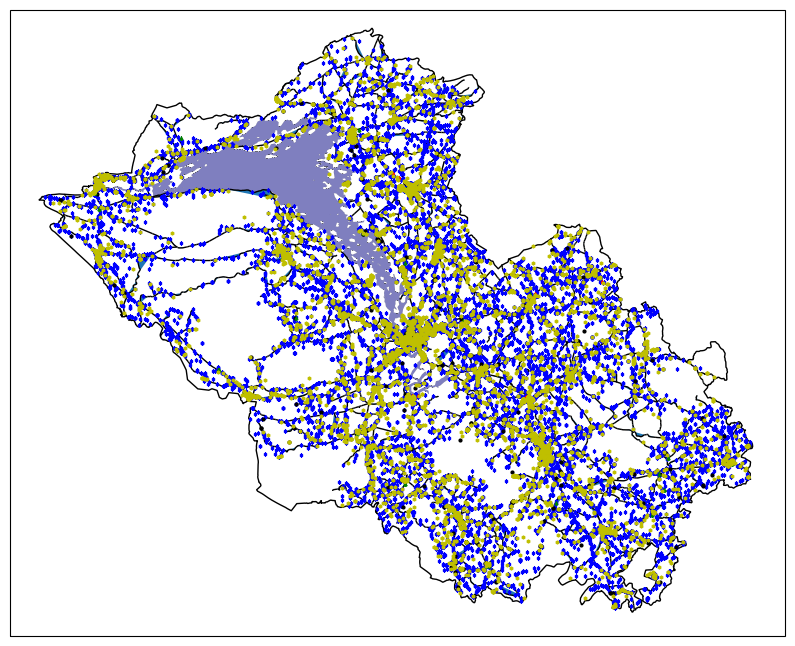

In [28]:
# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
residential=buildings.loc[buildings['CLASSIFICA']=='Residential']
residential_handle= ax.plot(residential.geometry.x, residential.geometry.y, 's', color='b', ms=2, transform=myCRS)

commercial=buildings.loc[buildings['CLASSIFICA']=='Commercial']
commercial_handle=ax.plot(commercial.geometry.x, commercial.geometry.y, 'o', color='k', ms=2, transform=myCRS)

education=buildings.loc[buildings['CLASSIFICA']=='Education']
education_handle=ax.plot(education.geometry.x, education.geometry.y, '^', color='g', ms=2, transform=myCRS)

health=buildings.loc[buildings['CLASSIFICA']=='Health']
health_handle=ax.plot(health.geometry.x, health.geometry.y, '*', color='r', ms=2, transform=myCRS)

other=buildings.loc[buildings['CLASSIFICA']=='Other']
other_handle=ax.plot(other.geometry.x, other.geometry.y, 'h', color='y', ms=2, transform=myCRS)

myFig2

In [29]:
# set a variable that will call whatever column we want to visualise on the map
#myFig2= small_area.explore('population_density', cmap='viridis')
# set the range for the choropleth

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

#pop_density=small_area.plot(column='residents', ax=ax, vmax=10000, cmap='magma',
                       #legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})


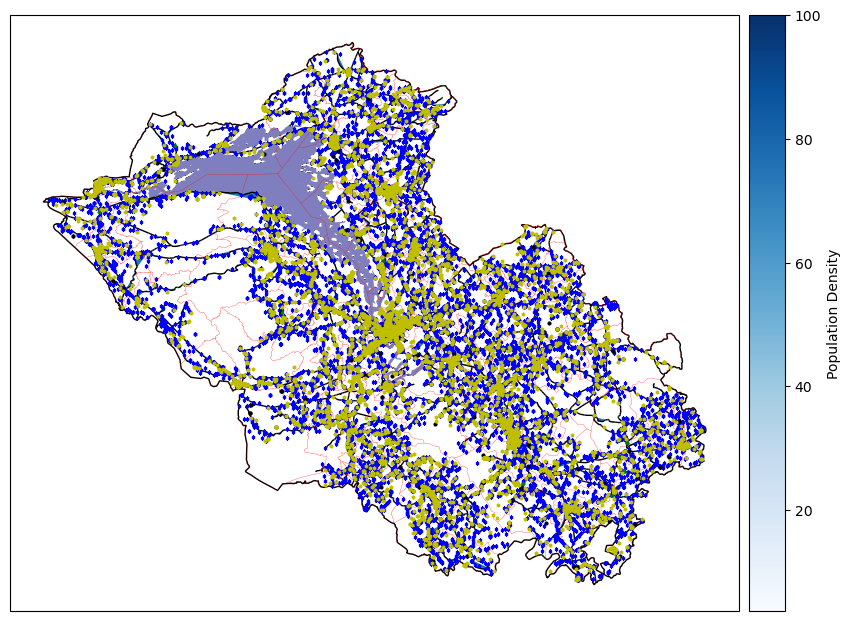

<Figure size 640x480 with 0 Axes>

In [30]:
small_area_plot = small_area.plot(column='pop_density', ax=ax, vmax=100, cmap='Blues',
                       legend=True, cax=cax, legend_kwds={'label': 'Population Density'})
sa_outline = ShapelyFeature(small_area['geometry'], myCRS, edgecolor='r',linewidth=0.1, facecolor='none')
ax.add_feature(sa_outline)
myFig2

In [31]:
roads_handle = [mlines.Line2D([], [], color='k')]
flood_handle = generate_handles(['Flood'], ['navy'])

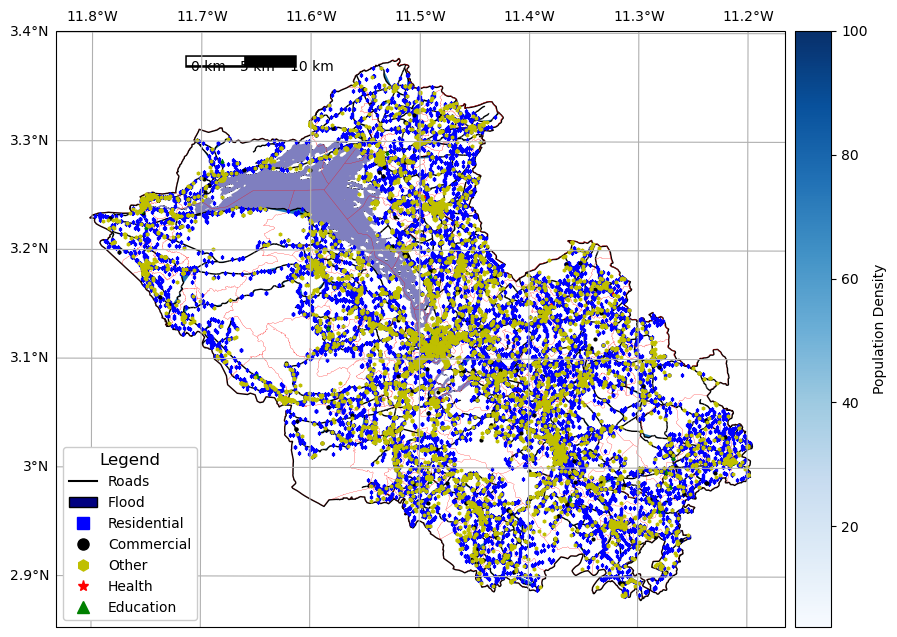

In [32]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects
# you want to add to the legend
handles = roads_handle  + flood_handle + residential_handle + commercial_handle + other_handle + health_handle + education_handle # use '+' to concatenate (combine) lists
labels = ['Roads'] + ['Flood'] + ['Residential'] + ['Commercial'] + ['Other'] + ['Health'] + ['Education']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left',markerscale=4, frameon=True, framealpha=1)


gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k') # draw  labels for the grid lines
                         
gridlines.right_labels = False # turn off the left-side labels
gridlines.bottom_labels = False

scale_bar(ax)
myFig2 # to show the updated figure

In [33]:
#create % column for elderly and child ?

In [34]:
#all data shapefile clipped to flood polygon with within

In [35]:
#analyses:-tot pop in flood polygon
#         - nbr resident houses
#         - tot length of road impacted and class A roas
#         - Sa with highest pop density and if any are adjacent
#         - SA with less than avg pop density
#         - which landcover types has highest area in flood poly
#         - total area flooded per landcover types
#         - SA with highest % of elderly/child
#         - SA with low pop density but high child %
#         - SA with medical building
#         - residential building furtherest from medical build (use original dataset ?)
#         - SA centre furthest from medical building

In [36]:
#add scale and legend handle

In [37]:
#create map and add features to map
# do second map with landcover

In [38]:
#different labels depending on building class and road class

In [39]:
#grid lines